In [44]:
%matplotlib inline
import cv2
import numpy as np
import os
from imutils import paths
import matplotlib.pyplot as plt

In [3]:
DatasetPath = "../data/images/INRIAPerson"

In [5]:
os.listdir(DatasetPath)

['.DS_Store', 'train_64x128_H96', 'test_64x128_H96']

In [6]:
train_dir =  'train_64x128_H96'
test_dir =  'test_64x128_H96'

In [22]:
#For preparing train data
def get_train_data(dataset_path,train_dir):
    imagepaths = paths.list_images(os.path.join(dataset_path,train_dir))
    images = []
    labels = []
    for imagepath in imagepaths:
        label = imagepath.split(os.path.sep)[-2]
        image = cv2.imread(imagepath,cv2.IMREAD_COLOR)
        images.append(image)
        if label == 'posPatches':
            labels.append(1)
        else:
            labels.append(-1)
    
    print("The size of the train dataset is {}".format(len(images)))        
    return images,labels

In [23]:
#For preparing test data
def get_test_data(dataset_path,test_dir):
    imagepaths = paths.list_images(os.path.join(dataset_path,train_dir))
    images = []
    labels = []
    for imagepath in imagepaths:
        label = imagepath.split(os.path.sep)[-2]
        image = cv2.imread(imagepath,cv2.IMREAD_COLOR)
        images.append(image)
        if label == 'posPatches':
            labels.append(1)
        else:
            labels.append(-1)
    print("The size of the test dataset is {}".format(len(images)))       
    return images,labels

In [24]:
train_images,train_labels = get_train_data(DatasetPath,train_dir)
test_images,test_labels = get_test_data(DatasetPath,test_dir)

The size of the train dataset is 14596
The size of the test dataset is 14596


In [25]:
def SVM_Init(C,gamma):
    model = cv2.ml.SVM_create()
    model.setGamma(gamma)
    model.setC(C)
    model.setKernel(cv2.ml.SVM_LINEAR)
    model.setType(cv2.ml.SVM_C_SVC)
    model.setTermCriteria((cv2.TERM_CRITERIA_EPS + 
                         cv2.TERM_CRITERIA_MAX_ITER, 
                         1000, 1e-3))
    return model

def SVM_train(model,data,labels):
    model.train(data,cv2.ml.ROW_SAMPLE,labels)

def SVM_predict(model,samples):
    return model.predict(samples)[1].ravel()

In [26]:
#Define hog descriptor
winSize = (64, 128)
blockSize = (16, 16)
blockStride = (8, 8)
cellSize = (8, 8)
nbins = 9
derivAperture = 1
winSigma = -1
histogramNormType = 0
L2HysThreshold = 0.2
gammaCorrection = True
nlevels = 64
signedGradient = False

# Initialize HOG
hog = cv2.HOGDescriptor(winSize, blockSize, blockStride,
                      cellSize, nbins,derivAperture,
                      winSigma, histogramNormType, L2HysThreshold, 
                      gammaCorrection, nlevels,signedGradient)

In [27]:
def compute_hog_features(hog,images):
    features = []
    for image in images:
        feature = hog.compute(image)
        features.append(feature)
    features = np.array(features).reshape(-1,len(features[0]))
    return features

In [28]:
train_data = compute_hog_features(hog,train_images)
train_labels = np.array(train_labels)

In [29]:
test_data =compute_hog_features(hog,test_images)
test_labels = np.array(test_labels)

In [30]:
print(train_data.shape,test_data.shape)

(14596, 3780) (14596, 3780)


In [31]:
svc = SVM_Init(0.01,0)

In [32]:
SVM_train(svc,train_data,train_labels)

In [33]:
test_labels = np.array(test_labels)
predictions = SVM_predict(svc,test_data)
accuracy = (test_labels == predictions).mean()
print("The accuracy of the model is {}".format(accuracy))

The accuracy of the model is 0.9914360098657167


In [38]:
#For creating SVM Detector
sv = svc.getSupportVectors()
rho,alpha,svidx = svc.getDecisionFunction(0)
svm_detector = np.zeros(sv.shape[1] + 1,dtype = sv.dtype)
svm_detector[:-1] = -sv[0,:]
svm_detector[-1] = rho

In [57]:
image_path = "../data/images/pedestrians/3.jpg"
image = cv2.imread(image_path)
print(image.shape)

(600, 403, 3)


In [53]:
hog.setSVMDetector(svm_detector)

144 229 98 196
0 90 190 434


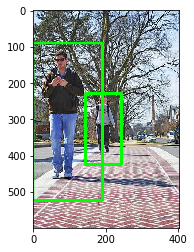

In [54]:
bboxes, weights = hog.detectMultiScale(image, winStride=(8, 8),
                                           padding=(32, 32), scale=1.05,
                                           finalThreshold=2, hitThreshold=1.0)
for box in bboxes:
    x,y,w,h = box
    print(x,y,w,h)
    cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),5,cv2.LINE_AA)
    
plt.imshow(image[:,:,::-1])

In [55]:
svm_detector_opencv = cv2.HOGDescriptor_getDefaultPeopleDetector()

In [56]:
hog.setSVMDetector(svm_detector_opencv)

In [ ]:
bboxes, weights = hog.detectMultiScale(image, winStride=(8, 8),
                                           padding=(32, 32), scale=1.05,
                                           finalThreshold=2, hitThreshold=1.0)
for box in bboxes:
    x,y,w,h = box
    print(x,y,w,h)
    cv2.rectangle(image,(x,y),(x+w,y+h),(0,0,),5,cv2.LINE_AA)
    
plt.imshow(image[:,:,::-1])